In [1]:
from result_saver import SaverProvider

provider = SaverProvider()

In [176]:
from Scratch import load_calibration_memory

DEVICE = 'ibm_sherbrooke'
DATE = '2024-03-24'

all_memories, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=DATE, double_msmt=True, post_process=True)



Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 17:49:53.348518+00:00.


In [177]:
import numpy as np

pSoftValue_list = []
for qubit, data in all_memories.items():
    gmm = gmm_dict[qubit]['gmm']
    scaler = gmm_dict[qubit]['scaler']

    if gmm.means_[0] > gmm.means_[1]:
            gmm.means_ = gmm.means_[::-1]
            gmm.weights_ = gmm.weights_[::-1]
            print("Warning: GMM means were inverted to match the expected order of the classes (0, 1)")
    
    IQ_data = np.hstack([data['mmr_0'], data['mmr_1'], data['mmr_1_scnd'], data['mmr_0_scnd']])
    IQ_data_real = IQ_data.real.reshape(-1, 1)
    IQ_data_scaled = scaler.transform(IQ_data_real)

    probas = gmm.predict_proba(IQ_data_scaled)

    pSoftValues = 1 / (1 + np.max(probas, axis=1) / np.min(probas, axis=1))
    pSoftValue_list.append(pSoftValues)

pSoft = np.hstack(pSoftValue_list)
print(pSoft.shape)


(7920355,)


In [178]:
import pickle

with open('pSoft.pkl', 'wb') as f:
    pickle.dump(pSoft, f)

with open('msmt_err_dict.pkl', 'wb') as f:
    pickle.dump(msmt_err_dict, f)

In [179]:
print(f"mean pSoft: {np.mean(pSoft)}")
print(f"std pSoft: {np.std(pSoft)}")

np.mean(pSoft.flatten())

mean pSoft: 0.005540657327526531
std pSoft: 0.03663705102884955


0.005540657327526531

# Sample function

In [6]:
import numpy as np

def sample_from_histogram(data, bins, n_samples, seed=42):
    count, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pmf = count / np.sum(count)
    cdf = np.cumsum(pmf)

    np.random.seed(seed)
    random_numbers = np.random.rand(n_samples)
    sampled_indices = np.searchsorted(cdf, random_numbers)

    return bin_centers[sampled_indices]

In [ ]:
# from scipy.interpolate import interp1d

# def sample_from_histogram(data, bins, n_samples, seed=42):
#     count, bin_edges = np.histogram(data, bins=bins)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     pmf = count / np.sum(count)
#     cdf = np.cumsum(pmf)

#     np.random.seed(seed)
#     random_numbers = np.random.rand(n_samples)
#     sampled_indices = np.searchsorted(cdf, random_numbers)

#     return bin_centers[sampled_indices]

# def generate_means_factors(pSoft, bins, n_samples, factors):
#     means = [np.mean(sample_from_histogram_and_adjust(pSoft.flatten(), bins=bins, 
#                                                       n_samples=n_samples, multiplicative_factor=mult_factor)) 
#              for mult_factor in factors]
#     return means, factors


# def find_multiplicative_factor_for_mean(target_mean, means, factors):
#     # Ensure that 'means' and 'factors' are sorted by 'means'
#     # This step is crucial for interpolation to work correctly
#     means, factors = zip(*sorted(zip(means, factors)))
    
#     # Fit the interpolator
#     interp = interp1d(means, factors, kind='linear', fill_value="extrapolate")
    
#     # Use the interpolator to find the multiplicative factor for the target mean
#     target_factor = interp(target_mean)
#     return target_factor


# def adjust_samples_to_match_mean_variance(samples, og_mean, og_variance, needed_factor, means, factors):
#     # Calculate current mean and std deviation of the samples
#     samples_mean = np.mean(samples)
#     samples_std = np.std(samples)
    
#     # Calculate target std deviation from the target variance
#     og_std = np.sqrt(og_variance)
    
#     # Adjust samples
#     # if multiplicative_factor < 1:
#     #     adjusted_samples = ((samples - samples_mean) / samples_std) * target_std * multiplicative_factor + original_mean * multiplicative_factor
#     #     # Leave target_std as is 
#     # if multiplicative_factor > 1:
#     #     diff_mean = original_mean * multiplicative_factor - samples_mean
#     #     adjusted_samples = samples + diff_mean

#     factor = find_multiplicative_factor_for_mean(og_variance*needed_factor, means, factors)

#     adjusted_samples = ((samples - samples_mean) / samples_std) * og_std * factor + og_mean * factor

#     offset = 1e-4
#     mask_below = adjusted_samples < 0
#     mask_above = adjusted_samples > 0.5
#     random_offsets_below = np.random.uniform(0, offset, mask_below.sum())
#     random_offsets_above = np.random.uniform(0, -offset, mask_above.sum())

#     adjusted_samples_clipped = adjusted_samples.copy()
#     adjusted_samples_clipped[mask_below] = 0 + random_offsets_below
#     adjusted_samples_clipped[mask_above] = 0.5 + random_offsets_above
    
#     return adjusted_samples_clipped


# def sample_from_histogram_and_adjust(data, bins, n_samples, needed_factor = 1, seed=42):
#     count, bin_edges = np.histogram(data, bins=bins)
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     pmf = count / np.sum(count)
#     cdf = np.cumsum(pmf)
    
#     np.random.seed(seed)
#     random_numbers = np.random.rand(n_samples)
#     sampled_indices = np.searchsorted(cdf, random_numbers)
#     sampled_data = bin_centers[sampled_indices]
    
#     # Adjust the sampled data to match the mean and variance of the original data
#     og_mean = np.mean(data) 
#     og_var = np.var(data) 
#     to_be_tested_factors = np.linspace(0.001, 20, 500)
#     means, factors = generate_means_factors(data, bins, n_samples, to_be_tested_factors)
#     adjusted_samples = adjust_samples_to_match_mean_variance(sampled_data, og_mean, og_var, needed_factor, means, factors)
    
#     return adjusted_samples


In [171]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm

def sample_from_histogram(data, bins, n_samples, seed=42):
    np.random.seed(seed)
    count, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pmf = count / np.sum(count)
    cdf = np.cumsum(pmf)
    random_numbers = np.random.rand(n_samples)
    sampled_indices = np.searchsorted(cdf, random_numbers)
    return bin_centers[sampled_indices]

def generate_means_factors(data, bins, n_samples, factors, seed=42):
    means = []
    for mult_factor in factors:
        sampled_data = sample_from_histogram(data, bins, n_samples, seed=seed)
        adjusted_samples = adjust_samples_to_match_mean_variance(
            sampled_data, np.mean(data), np.var(data), mult_factor)
        means.append(np.mean(adjusted_samples))
    return means, factors

def adjust_samples_to_match_mean_variance(samples, og_mean, og_variance, factor):
    samples_mean = np.mean(samples)
    samples_std = np.std(samples)
    og_std = np.sqrt(og_variance)
    adjusted_samples = ((samples - samples_mean) / samples_std) * og_std * factor + og_mean * factor
    adjusted_samples = np.clip(adjusted_samples, 0, 0.5)  # Ensuring values stay within 0 and 0.5
    return adjusted_samples

def find_multiplicative_factor_for_mean(target_mean, means, factors):
    means, factors = zip(*sorted(zip(means, factors)))
    interp = interp1d(means, factors, kind='linear', fill_value="extrapolate")
    return interp(target_mean)

def sample_from_histogram_and_adjust(data, bins, n_samples, needed_factor=1, seed=42):
    np.random.seed(seed)
    to_be_tested_factors = np.linspace(0.001, 20, 20)
    means, factors = generate_means_factors(data, bins, n_samples, to_be_tested_factors, seed=seed)
    sampled_data = sample_from_histogram(data, bins, n_samples, seed=seed)
    factor = find_multiplicative_factor_for_mean(np.mean(data) * needed_factor, means, factors)
    adjusted_samples = adjust_samples_to_match_mean_variance(sampled_data, np.mean(data), np.var(data), factor)
    return adjusted_samples


Mean of original data: 0.00848
Std of original data: 0.04578
Mean of sampled data: 0.00956
Std of sampled data: 0.04427
Mean of adjusted sampled data: 0.01711
Std of adjusted sampled data: 0.07787


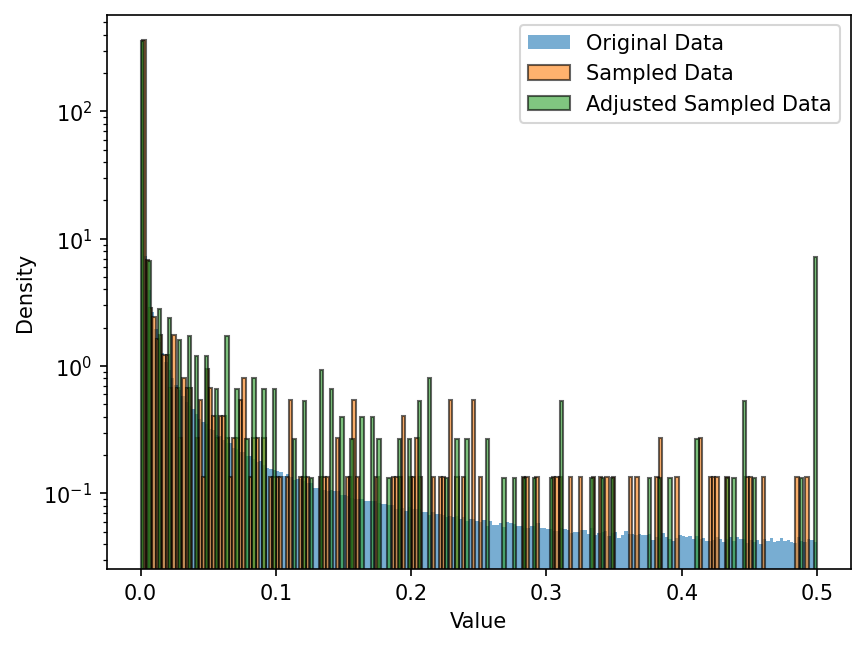

In [175]:
import matplotlib.pyplot as plt

bins = 200
n_samples = 3000

# Sample from the histogram
data = pSoft.flatten()
sampled_data = sample_from_histogram(data, bins, n_samples = n_samples, seed=42)
sampled_data2 = sample_from_histogram_and_adjust(data, bins, n_samples = n_samples, needed_factor=2, seed=42)
# sampled_data2 = sample_with_mean_variance_control(data, bins, n_samples, target_mean=np.mean(data), 
#                                                   target_std=np.std(data), tolerance=0.3, max_iterations=100_000)

print(f"Mean of original data: {np.mean(data):.5f}")
print(f"Std of original data: {np.std(data):.5f}")
print(f"Mean of sampled data: {np.mean(sampled_data):.5f}")
print(f"Std of sampled data: {np.std(sampled_data):.5f}")
print(f"Mean of adjusted sampled data: {np.mean(sampled_data2):.5f}")
print(f"Std of adjusted sampled data: {np.std(sampled_data2):.5f}")

# Plot the original histogram and the sampled data
plt.figure(dpi=150)
plt.hist(data, bins=bins, density=True, alpha=0.6, label='Original Data')
plt.hist(sampled_data, bins=bins, density=True, alpha=0.6, label='Sampled Data', edgecolor='black')
plt.hist(sampled_data2, bins=bins, density=True, alpha=0.6, label='Adjusted Sampled Data', edgecolor='black')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [62]:
0.04 **2

0.0016

# Distribution sampling

In [147]:
import numpy as np
from scipy.stats import beta


def generate_skewed_samples(n, target_mean, target_variance, a, b):
    # Generate samples from a skewed Beta distribution
    samples_beta = beta.rvs(a, b, size=n)
    
    # Scale samples to the [0, 0.5] interval directly
    scaled_samples = samples_beta * 0.5

    # Attempt to match the target mean and variance through scaling
    # Note: Direct scaling might not perfectly achieve the target mean and variance due to the fixed interval
    scale = np.sqrt(target_variance / np.var(scaled_samples))
    shift = (target_mean - np.mean(scaled_samples)) * scale
    
    # Adjusted samples might need re-scaling to fit within the [0, 0.5] interval
    # This step is crucial as the previous scaling could have shifted values outside the desired range
    adjusted_samples = np.clip(scaled_samples * scale + shift, 0, 0.5)

    return adjusted_samples

n = 1000
og_mean = 0.02
og_var = 0.05
# Adjust alpha (a) and beta (b) for desired skewness; these are initial estimates
a, b = 3, 3 # Example values; adjust as needed for skewness

samples = generate_skewed_samples(n, og_mean, og_var, a, b)

print(f"Sample Mean: {np.mean(samples):.3f}, Target Mean: {og_mean}")
print(f"Sample Variance: {np.var(samples):.3f}, Target Variance: {og_var}")

print(f"Min: {np.min(samples)}, Max: {np.max(samples)}")

Sample Mean: 0.116, Target Mean: 0.02
Sample Variance: 0.021, Target Variance: 0.05
Min: 0.0, Max: 0.5


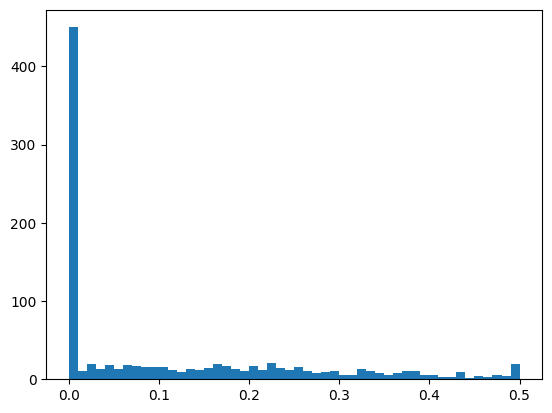

In [148]:
plt.hist(samples, bins=50)
plt.show()

In [110]:
import numpy as np

def generate_samples(n, target_mean, target_variance, interval=(0, 0.5)):
    # Adjust these parameters as needed to fit the desired distribution characteristics
    adjusted_mean = target_mean
    adjusted_std = np.sqrt(target_variance)
    
    # Initial sample generation
    samples = np.random.normal(adjusted_mean, adjusted_std, size=n * 10)
    
    # Rejection sampling: Keep samples within the desired interval
    samples = samples[(samples >= interval[0]) & (samples <= interval[1])]
    
    # If not enough samples after filtering, this loop retries until enough are collected
    while len(samples) < n:
        extra_samples = np.random.normal(adjusted_mean, adjusted_std, size=n * 10)
        extra_samples = extra_samples[(extra_samples >= interval[0]) & (extra_samples <= interval[1])]
        samples = np.concatenate([samples, extra_samples])
    
    # Adjusting the sample size to n
    samples = samples[:n]
    
    # Placeholder for possible adjustment methods to more closely match the target mean and variance
    
    return samples

n = 2000
og_mean = 0.008  # Example mean
og_var = 0.045  # Example variance
samples = generate_samples(n, og_mean, og_var)

print(f"Sample Mean: {np.mean(samples)}, Target Mean: {og_mean}")
print(f"Sample Variance: {np.var(samples)}, Target Variance: {og_var}")
print(f"Min: {np.min(samples)}, Max: {np.max(samples)}")


Sample Mean: 0.16382410588155263, Target Mean: 0.008
Sample Variance: 0.0136656289970392, Target Variance: 0.045
Min: 1.0431969282291564e-05, Max: 0.4998845440191902
